In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

%matplotlib widget

# if 'cantera/build' not in sys.path[0]:
#     sys.path.insert(0, '/Users/speth/src/cantera/build/python')
import cantera as ct
print(ct.__version__, ct.__git_commit__, ct.__file__)

3.0.0a5 e45876491 /Users/walkerant/mambaforge/envs/ct-dev/lib/python3.10/site-packages/cantera/__init__.py


In [2]:
class MySolution(ct.Solution):
    "Wrapper to allow assignment of custom attributes"

class PhotolysisReactor(ct.ExtensibleIdealGasConstPressureReactor):
    def before_eval(self, t, LHS, RHS):
        # Sample version of this that has the right periodicity. A full implementation would use the
        # latitude and longitude. Clipping accounts for the period where the sun is behind the earth.
        self.thermo.zenith_angle = np.clip(np.mod(2*np.pi*t / (24*60*60), 2*np.pi), 0, np.pi) - np.pi/2


In [3]:
gas = MySolution('photolysis-sza.yaml')
gas.TPX = 300, 101325, 'H2O:1.0'

r = PhotolysisReactor(gas)
r.energy_enabled = False
net = ct.ReactorNet([r])
states = ct.SolutionArray(gas, extra=['t', 'kf'])
while net.time < 2*24*60*60:
    net.advance(net.time + 5)
    states.append(state=r.thermo.state, t=net.time, kf=r.thermo.forward_rate_constants[0])


[5.00000e+00 1.00000e+01 1.50000e+01 ... 1.72790e+05 1.72795e+05
 1.72800e+05]


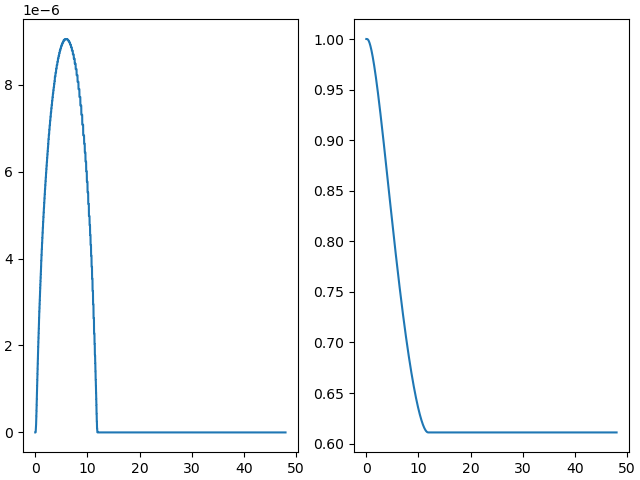

In [4]:
f, ax = plt.subplots(1, 2)
ax[0].plot(states.t / 3600, states.kf)
ax[1].plot(states.t / 3600, states('H2O').X)
